# Grad-CAM Analysis for Architectural Style Classification

This notebook implements **Gradient-weighted Class Activation Mapping (Grad-CAM)** to visualize
which regions of an architectural image the trained CNN focuses on when making classification decisions.

**Workflow:**
1. Select a trained model checkpoint
2. Provide a single architectural image
3. Generate Grad-CAM heatmap showing model attention regions
4. View predictions with confidence scores

**Reference:** Selvaraju et al., *Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization* (2017)

In [1]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

import torch
import torch.nn.functional as F
from torchvision import transforms

# Add house_classification to sys.path so we can reuse model definitions
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / "house_classification"))

from model import VanillaCNN, get_pretrained_model
from utils.config import get_data_paths

print(f"Project root: {PROJECT_ROOT}")
print(f"PyTorch version: {torch.__version__}")

Project root: /Users/tawate/Documents/Architecture_Image_Modeling
PyTorch version: 2.8.0


In [2]:
# Device selection (same pattern as train.py / evaluate.py)
def get_device() -> torch.device:
    """Get the best available device."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

DEVICE = get_device()
print(f"Using device: {DEVICE}")

# ImageNet normalization (matches conf/training_config.yaml)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Class names (from training directory structure, alphabetically sorted)
CLASS_NAMES = [
    "american_craftsman", "american_foursquare", "cape_cod", "colonial",
    "edwardian", "georgian", "gothic", "greek_revival", "romanesque", "tudor_revival"
]
NUM_CLASSES = len(CLASS_NAMES)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")

Using device: mps
Number of classes: 10
Classes: ['american_craftsman', 'american_foursquare', 'cape_cod', 'colonial', 'edwardian', 'georgian', 'gothic', 'greek_revival', 'romanesque', 'tudor_revival']


In [3]:
def get_inference_transform(image_size: int = 224) -> transforms.Compose:
    """Inference preprocessing matching the val/test pipeline in data_loaders.py."""
    return transforms.Compose([
        transforms.Resize(int(image_size * 1.14)),  # 256 when image_size=224
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])


def load_image(image_path: str) -> Image.Image:
    """Load an image and convert to RGB."""
    img = Image.open(image_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    return img


def denormalize(tensor: torch.Tensor) -> np.ndarray:
    """Reverse ImageNet normalization for display. Returns HWC numpy array in [0,1]."""
    mean = np.array(IMAGENET_MEAN).reshape(3, 1, 1)
    std = np.array(IMAGENET_STD).reshape(3, 1, 1)
    img = tensor.cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img.transpose(1, 2, 0)  # CHW -> HWC

In [4]:
class GradCAM:
    """Grad-CAM: Gradient-weighted Class Activation Mapping.

    Registers forward and backward hooks on a target convolutional layer to
    capture activations and gradients, then computes the gradient-weighted
    activation map.

    Args:
        model: Trained PyTorch model in eval mode.
        target_layer: The convolutional layer (nn.Module) to visualize.
    """

    def __init__(self, model: torch.nn.Module, target_layer: torch.nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Register hooks
        self._forward_hook = target_layer.register_forward_hook(self._save_activation)
        self._backward_hook = target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        """Forward hook: capture the output activations of the target layer."""
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        """Backward hook: capture the gradients flowing back through the target layer."""
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor: torch.Tensor, target_class: int = None) -> np.ndarray:
        """Generate the Grad-CAM heatmap for a single image.

        Args:
            input_tensor: Preprocessed image tensor of shape (1, 3, 224, 224).
            target_class: Class index to generate the heatmap for.
                         If None, uses the predicted (argmax) class.

        Returns:
            np.ndarray: Heatmap of shape (H, W) with values in [0, 1].
        """
        self.model.eval()
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backpropagate the target class score
        self.model.zero_grad()
        target_score = output[0, target_class]
        target_score.backward()

        # Global average pool the gradients -> channel weights
        weights = self.gradients.mean(dim=(2, 3)).squeeze(0)  # (C,)
        activations = self.activations.squeeze(0)  # (C, H, W)

        # Weighted combination of activation maps
        cam = torch.zeros(activations.shape[1:], dtype=activations.dtype,
                         device=activations.device)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # ReLU - only keep positive contributions
        cam = F.relu(cam)

        # Normalize to [0, 1]
        cam = cam.cpu().numpy()
        if cam.max() > 0:
            cam = cam / cam.max()

        return cam

    def remove_hooks(self):
        """Remove the registered hooks to free memory."""
        self._forward_hook.remove()
        self._backward_hook.remove()

In [5]:
def get_target_layer(model: torch.nn.Module, model_name: str) -> torch.nn.Module:
    """Return the target convolutional layer for Grad-CAM based on model architecture."""
    target_layers = {
        # VanillaCNN: last Conv2d in features Sequential (index 12)
        "vanilla": lambda m: m.features[12],

        # ResNet: last residual block in stage 4
        "resnet18": lambda m: m.layer4[-1],
        "resnet34": lambda m: m.layer4[-1],
        "resnet50": lambda m: m.layer4[-1],

        # VGG: last conv layer before classifier
        "vgg16": lambda m: m.features[29],
        "vgg19": lambda m: m.features[36],

        # EfficientNet: last feature block
        "efficientnet_b0": lambda m: m.features[-1],
        "efficientnet_b1": lambda m: m.features[-1],

        # MobileNetV2: last feature block
        "mobilenet_v2": lambda m: m.features[-1],
    }

    if model_name not in target_layers:
        raise ValueError(
            f"Unknown model: {model_name}. "
            f"Supported: {list(target_layers.keys())}"
        )

    layer = target_layers[model_name](model)
    print(f"Target layer for '{model_name}': {type(layer).__name__}")
    return layer

In [6]:
def extract_model_name_from_checkpoint(checkpoint_path: str) -> str:
    """Extract model architecture name from checkpoint directory naming convention.

    Directories follow: {model}_ep{epochs}_bs{batch_size}_lr{lr}
    """
    dir_name = Path(checkpoint_path).parent.name

    # Check multi-word names first to avoid partial matches
    known_models = [
        "efficientnet_b0", "efficientnet_b1",
        "mobilenet_v2",
        "resnet18", "resnet34", "resnet50",
        "vgg16", "vgg19",
        "vanilla",
    ]

    for model in known_models:
        if dir_name.startswith(model + "_") or dir_name == model:
            return model

    raise ValueError(
        f"Could not detect model type from directory '{dir_name}'. "
        f"Known models: {known_models}"
    )


def load_model_from_checkpoint(checkpoint_path: str, model_name: str = None) -> tuple:
    """Load a trained model from a checkpoint file.

    Args:
        checkpoint_path: Path to the .pth checkpoint file.
        model_name: Model architecture name. If None, auto-detected from path.

    Returns:
        Tuple of (model, model_name, checkpoint_info_dict).
    """
    checkpoint_path = str(checkpoint_path)

    if model_name is None:
        model_name = extract_model_name_from_checkpoint(checkpoint_path)

    print(f"Model architecture: {model_name}")

    # Create model (pretrained=False since we load our own weights)
    if model_name == "vanilla":
        model = VanillaCNN(num_classes=NUM_CLASSES)
    else:
        model = get_pretrained_model(model_name, num_classes=NUM_CLASSES, pretrained=False)

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(DEVICE)
    model.eval()

    info = {
        "epoch": checkpoint.get("epoch", "unknown"),
        "val_loss": checkpoint.get("val_loss", "unknown"),
        "val_acc": checkpoint.get("val_acc", "unknown"),
    }

    print(f"Loaded checkpoint from epoch {info['epoch']}")
    if isinstance(info["val_loss"], float):
        print(f"  Validation loss: {info['val_loss']:.4f}")
    if isinstance(info["val_acc"], float):
        print(f"  Validation accuracy: {info['val_acc']:.2f}%")

    return model, model_name, info

In [7]:
def overlay_heatmap(image: np.ndarray, heatmap: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    """Overlay a Grad-CAM heatmap on an image.

    Args:
        image: Original image as HWC numpy array in [0, 1].
        heatmap: Grad-CAM heatmap of shape (h, w) in [0, 1].
        alpha: Blending weight for the heatmap.

    Returns:
        Blended image as HWC numpy array in [0, 1].
    """
    heatmap_resized = np.array(
        Image.fromarray((heatmap * 255).astype(np.uint8)).resize(
            (image.shape[1], image.shape[0]), resample=Image.BILINEAR
        )
    ) / 255.0

    colored_heatmap = cm.jet(heatmap_resized)[:, :, :3]  # Drop alpha channel
    blended = (1 - alpha) * image + alpha * colored_heatmap
    return np.clip(blended, 0, 1)


def visualize_gradcam(
    original_image: Image.Image,
    preprocessed_tensor: torch.Tensor,
    heatmap: np.ndarray,
    predicted_class: str,
    confidence: float,
    true_class: str = None,
    top_k_classes: list = None,
):
    """Create a comprehensive Grad-CAM visualization.

    Displays panels: original image, Grad-CAM heatmap, overlay, and top-K bar chart.
    """
    model_input_image = denormalize(preprocessed_tensor.squeeze(0))
    overlay = overlay_heatmap(model_input_image, heatmap, alpha=0.5)

    if top_k_classes:
        fig, axes = plt.subplots(1, 4, figsize=(22, 5))
    else:
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # Panel 1: Original image
    axes[0].imshow(original_image)
    title = f"Original Image\nPredicted: {predicted_class} ({confidence:.1%})"
    if true_class:
        match = "Correct" if true_class == predicted_class else "Incorrect"
        title += f"\nTrue: {true_class} ({match})"
    axes[0].set_title(title, fontsize=11)
    axes[0].axis("off")

    # Panel 2: Grad-CAM heatmap
    heatmap_display = np.array(
        Image.fromarray((heatmap * 255).astype(np.uint8)).resize(
            (224, 224), resample=Image.BILINEAR
        )
    ) / 255.0
    im = axes[1].imshow(heatmap_display, cmap="jet", vmin=0, vmax=1)
    axes[1].set_title("Grad-CAM Heatmap", fontsize=11)
    axes[1].axis("off")
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # Panel 3: Overlay
    axes[2].imshow(overlay)
    axes[2].set_title("Grad-CAM Overlay\n(on model input)", fontsize=11)
    axes[2].axis("off")

    # Panel 4: Top-K confidence bar chart
    if top_k_classes:
        names, probs = zip(*top_k_classes)
        names = list(reversed(names))
        probs = list(reversed(probs))
        colors = ["#2ecc71" if n == predicted_class else "#3498db" for n in names]
        axes[3].barh(names, probs, color=colors)
        axes[3].set_xlim(0, 1)
        axes[3].set_xlabel("Confidence")
        axes[3].set_title("Top-K Predictions", fontsize=11)
        for i, p in enumerate(probs):
            axes[3].text(p + 0.01, i, f"{p:.1%}", va="center", fontsize=9)

    plt.tight_layout()
    plt.show()

---
## Configuration

Set the model checkpoint and image path below. The model type is auto-detected from the checkpoint directory name.

In [8]:
# =============================================================================
# USER CONFIGURATION - Edit these values
# =============================================================================

# Path to the model checkpoint (.pth file)
CHECKPOINT_PATH = PROJECT_ROOT / "checkpoints" / "resnet18_ep50_bs32_lr0.001" / "best_model.pth"

# Path to a single image to analyze
IMAGE_PATH = PROJECT_ROOT / "architectural_style_images" / "test" / "colonial" / "colonial_16500.jpg"

# Optional: specify the true class if known (set to None if unknown)
TRUE_CLASS = "colonial"

# Optional: override model name (set to None for auto-detection from checkpoint path)
MODEL_NAME = None

# Number of top classes to show in the confidence bar chart
TOP_K = 5

# =============================================================================
# List available checkpoints for reference
# =============================================================================
checkpoints_dir = PROJECT_ROOT / "checkpoints"
if checkpoints_dir.exists():
    print("Available checkpoint directories:")
    for d in sorted(checkpoints_dir.iterdir()):
        if d.is_dir():
            best = "best_model.pth" if (d / "best_model.pth").exists() else ""
            final = "final_model.pth" if (d / "final_model.pth").exists() else ""
            print(f"  {d.name}/  [{best}  {final}]")

Available checkpoint directories:
  efficientnet_b0_ep50_bs32_lr0.001/  [best_model.pth  final_model.pth]
  mobilenet_v2_ep50_bs32_lr0.001/  [best_model.pth  final_model.pth]
  resnet18_ep50_bs32_lr0.001/  [best_model.pth  final_model.pth]
  resnet34_ep50_bs32_lr0.001/  [best_model.pth  final_model.pth]
  resnet50_ep50_bs32_lr0.001/  [best_model.pth  final_model.pth]
  vanilla_ep50_bs32_lr0.001/  [best_model.pth  final_model.pth]


In [9]:
# Load the model
print("=" * 60)
print("Loading model...")
print("=" * 60)
model, model_name, checkpoint_info = load_model_from_checkpoint(CHECKPOINT_PATH, MODEL_NAME)

# Get the target layer for Grad-CAM
target_layer = get_target_layer(model, model_name)

# Load and preprocess the image
print("\n" + "=" * 60)
print("Loading image...")
print("=" * 60)
original_image = load_image(str(IMAGE_PATH))
print(f"Image: {IMAGE_PATH.name}")
print(f"Original size: {original_image.size}")

transform = get_inference_transform()
input_tensor = transform(original_image).unsqueeze(0).to(DEVICE)
print(f"Input tensor shape: {input_tensor.shape}")

Loading model...
Model architecture: resnet18
Loaded checkpoint from epoch 12
  Validation loss: 1.2771
  Validation accuracy: 61.81%
Target layer for 'resnet18': BasicBlock

Loading image...
Image: colonial_16500.jpg
Original size: (2478, 1982)
Input tensor shape: torch.Size([1, 3, 224, 224])


In [10]:
# Initialize Grad-CAM
gradcam = GradCAM(model, target_layer)

# Forward pass to get predictions
input_tensor.requires_grad_(True)
with torch.enable_grad():
    output = model(input_tensor)
    probabilities = F.softmax(output, dim=1).squeeze(0)

# Get prediction results
predicted_idx = probabilities.argmax().item()
predicted_class = CLASS_NAMES[predicted_idx]
confidence = probabilities[predicted_idx].item()

# Get top-K predictions
top_k_probs, top_k_indices = probabilities.topk(TOP_K)
top_k_classes = [
    (CLASS_NAMES[idx.item()], prob.item())
    for idx, prob in zip(top_k_indices, top_k_probs)
]

print("=" * 60)
print("PREDICTION RESULTS")
print("=" * 60)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.1%}")
if TRUE_CLASS:
    match = "CORRECT" if TRUE_CLASS == predicted_class else "INCORRECT"
    print(f"True class: {TRUE_CLASS} ({match})")
print(f"\nTop-{TOP_K} predictions:")
for rank, (name, prob) in enumerate(top_k_classes, 1):
    marker = " <--" if name == predicted_class else ""
    print(f"  {rank}. {name}: {prob:.1%}{marker}")

# Generate Grad-CAM heatmap for the predicted class
print(f"\nGenerating Grad-CAM for: {predicted_class}")
heatmap = gradcam.generate(input_tensor, target_class=predicted_idx)
print(f"Heatmap shape: {heatmap.shape}")

# Clean up hooks
gradcam.remove_hooks()

PREDICTION RESULTS
Predicted class: cape_cod
Confidence: 67.9%
True class: colonial (INCORRECT)

Top-5 predictions:
  1. cape_cod: 67.9% <--
  2. colonial: 11.1%
  3. american_craftsman: 8.6%
  4. tudor_revival: 5.0%
  5. greek_revival: 4.5%

Generating Grad-CAM for: cape_cod
Heatmap shape: (7, 7)


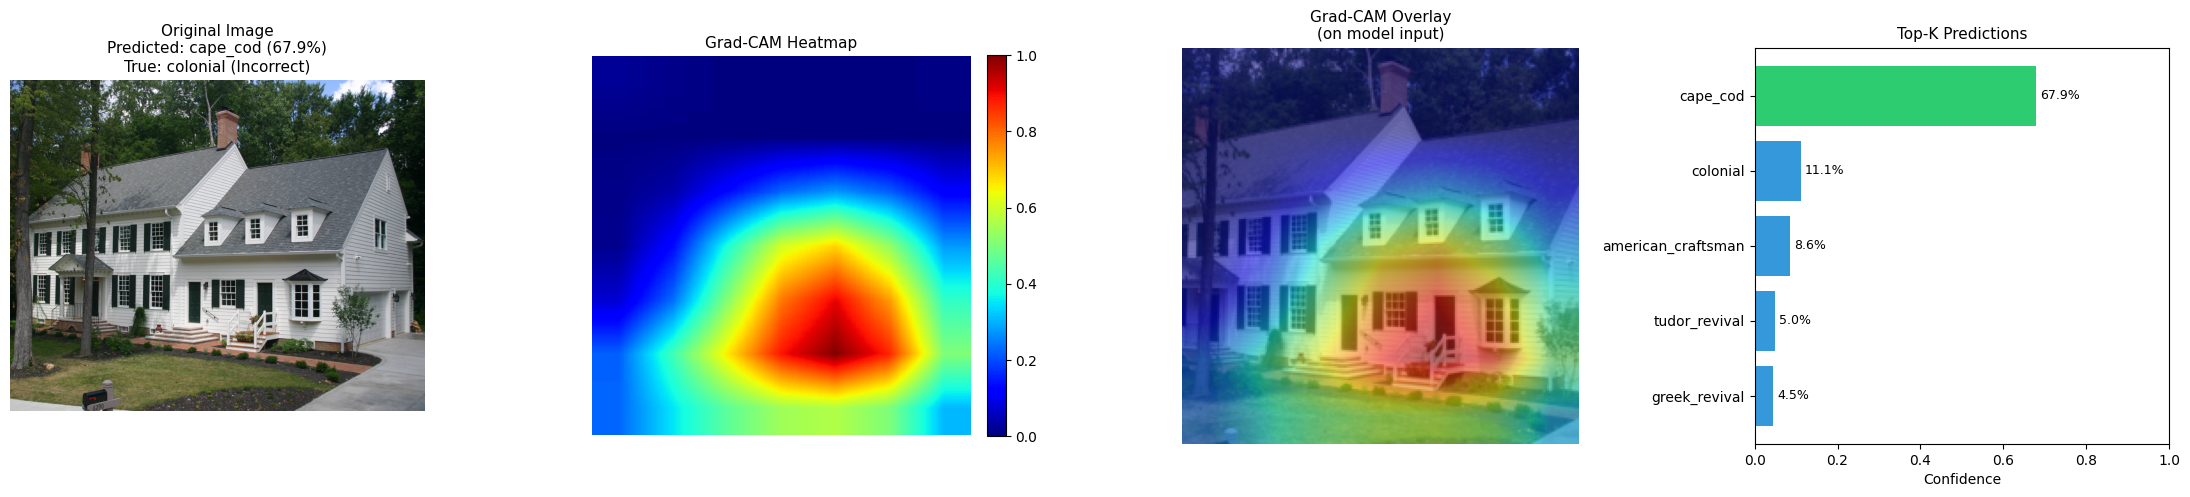

In [11]:
# Render the full visualization
visualize_gradcam(
    original_image=original_image,
    preprocessed_tensor=input_tensor.detach(),
    heatmap=heatmap,
    predicted_class=predicted_class,
    confidence=confidence,
    true_class=TRUE_CLASS,
    top_k_classes=top_k_classes,
)

---
## Grad-CAM for Alternate Classes

Compare what the model focuses on when considering different class predictions.
This helps understand what visual features distinguish one architectural style from another.

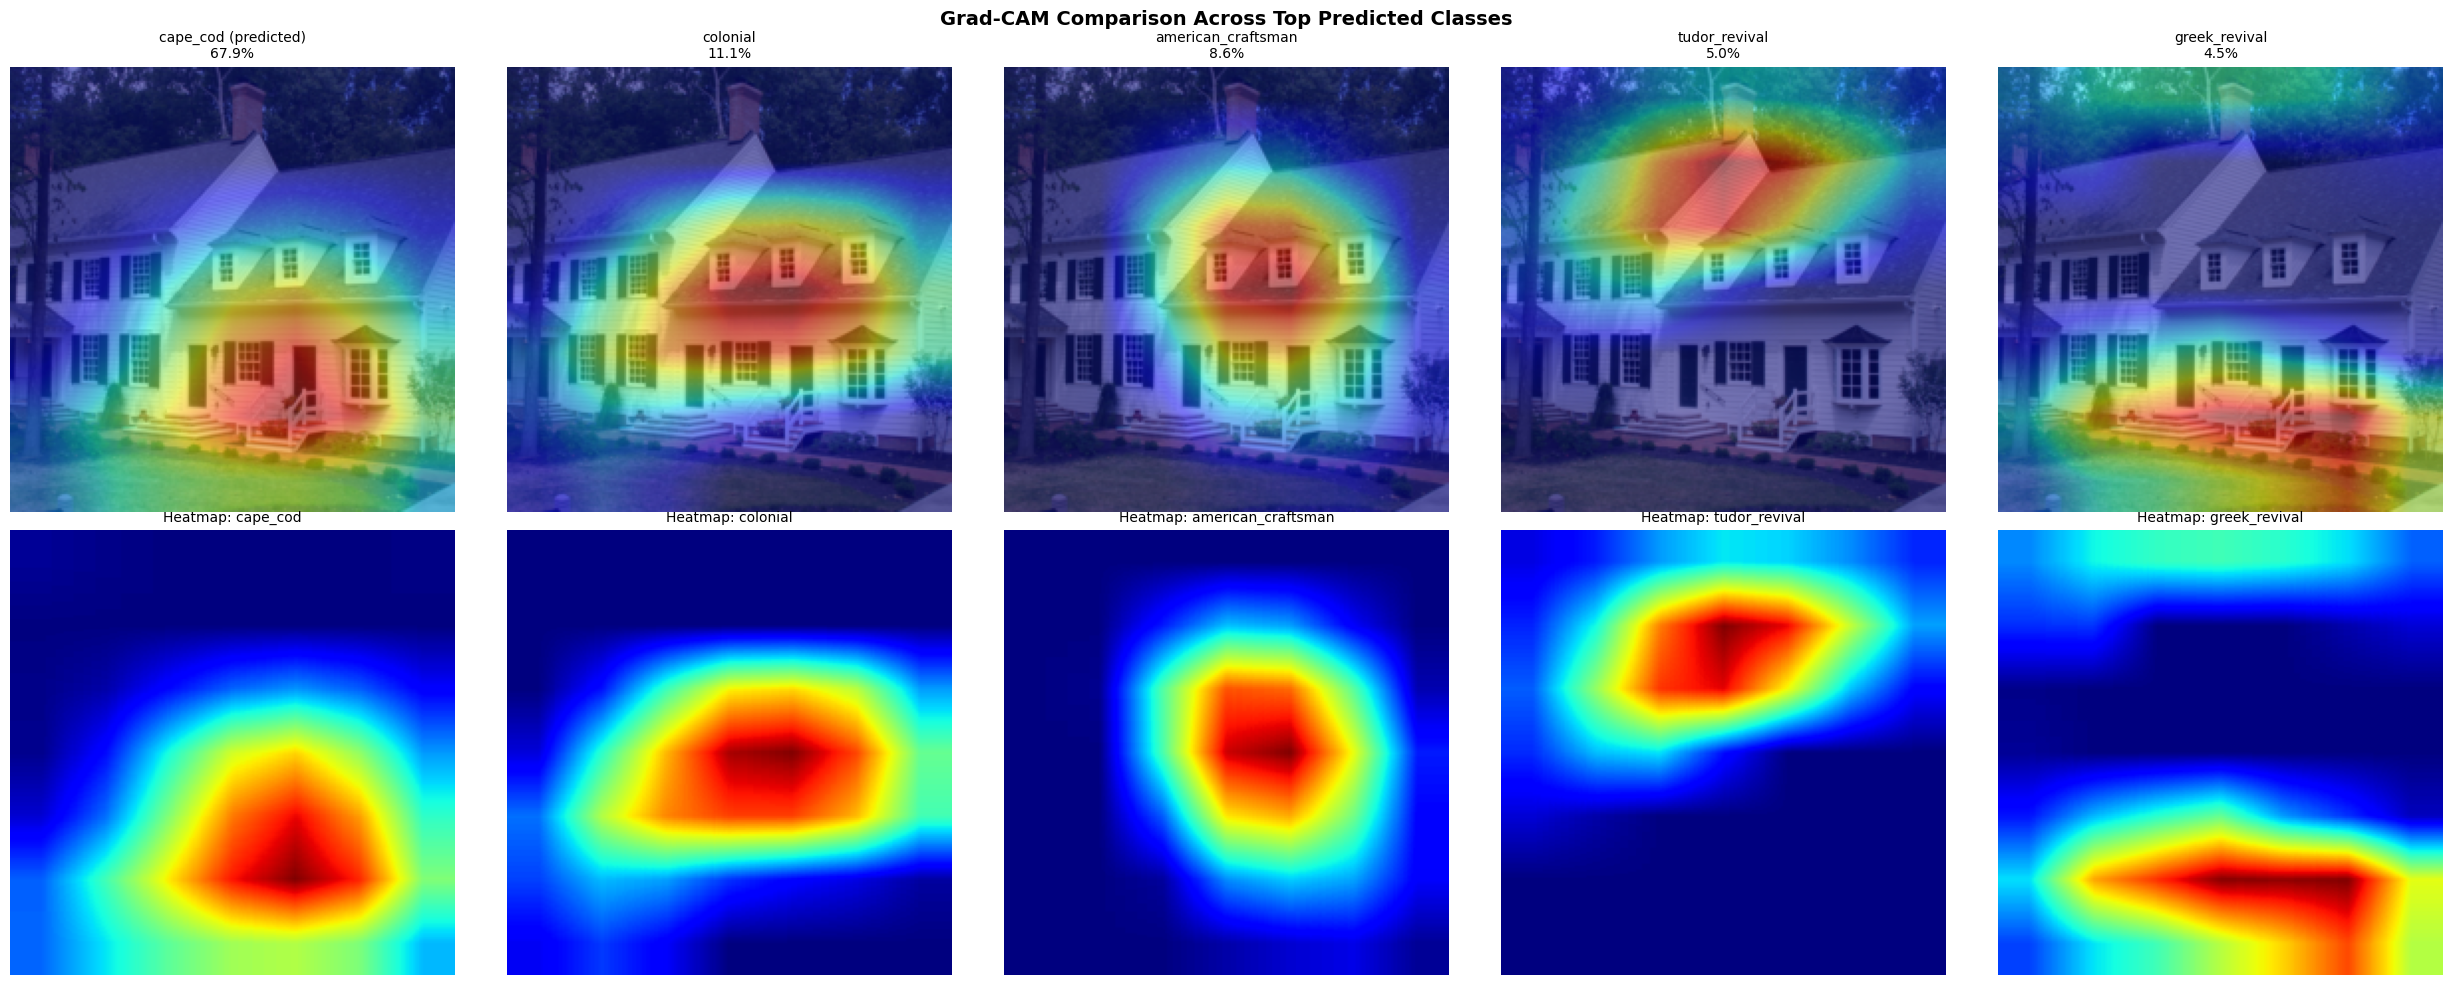

In [12]:
# Re-initialize Grad-CAM (hooks were removed above)
gradcam = GradCAM(model, target_layer)

# Generate heatmaps for each of the top-K classes
heatmaps_by_class = {}
for class_name, prob in top_k_classes:
    class_idx = CLASS_NAMES.index(class_name)
    # Fresh forward pass per class for clean gradients
    input_fresh = transform(original_image).unsqueeze(0).to(DEVICE)
    input_fresh.requires_grad_(True)
    heatmap_k = gradcam.generate(input_fresh, target_class=class_idx)
    heatmaps_by_class[class_name] = (heatmap_k, prob)

gradcam.remove_hooks()

# Visualize heatmaps side by side
model_input_image = denormalize(transform(original_image))
n_classes = len(heatmaps_by_class)
fig, axes = plt.subplots(2, n_classes, figsize=(5 * n_classes, 10))

for col, (class_name, (hmap, prob)) in enumerate(heatmaps_by_class.items()):
    # Top row: heatmap overlay
    overlay = overlay_heatmap(model_input_image, hmap, alpha=0.5)
    axes[0, col].imshow(overlay)
    marker = " (predicted)" if class_name == predicted_class else ""
    axes[0, col].set_title(f"{class_name}{marker}\n{prob:.1%}", fontsize=10)
    axes[0, col].axis("off")

    # Bottom row: raw heatmap
    hmap_resized = np.array(
        Image.fromarray((hmap * 255).astype(np.uint8)).resize(
            (224, 224), resample=Image.BILINEAR
        )
    ) / 255.0
    axes[1, col].imshow(hmap_resized, cmap="jet", vmin=0, vmax=1)
    axes[1, col].set_title(f"Heatmap: {class_name}", fontsize=10)
    axes[1, col].axis("off")

plt.suptitle("Grad-CAM Comparison Across Top Predicted Classes", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

---
## Interpreting the Results

**How to read the Grad-CAM heatmap:**
- **Red/warm regions**: Areas the model focuses on most strongly for that class prediction
- **Blue/cool regions**: Areas the model considers less important
- **Overlay**: Shows which parts of the actual architectural image drive the classification

**What to look for:**
- Does the model focus on architecturally meaningful features (rooflines, columns, windows, facade details)?
- Or does it rely on context clues (landscaping, sky, neighboring structures)?
- When comparing across classes, do the attention regions shift to different structural elements?

**Common patterns in architectural classification:**
- **Colonial**: Symmetric facade, central doorway, evenly spaced windows
- **Tudor Revival**: Half-timbering, steep gables, prominent chimneys
- **Greek Revival**: Columned porticos, pediments, symmetrical design
- **Gothic**: Pointed arches, vertical emphasis, ornate detailing
- **Cape Cod**: Steep roof, dormer windows, central chimney
- **Georgian**: Rigid symmetry, decorative crown, paneled front door